# Facial Expression Recognition

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os

from tensorflow import keras
from keras import Model, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Add, BatchNormalization, Activation, Dropout, PReLU, ELU, ReLU
from keras.regularizers import l1, l2, l1_l2
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [2]:
df = {}
for expression in os.listdir(r"D:\Utkarsh Mathur\Career\Data Science\Datasets\FER 2013\train/"):
    directory = r"D:\Utkarsh Mathur\Career\Data Science\Datasets\FER 2013\train/" + expression
    df[expression] = len(os.listdir(directory))
df = pd.DataFrame(df, index=[0])

In [3]:
img_size = 48
batch_size = 64

train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True)

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(r"D:\Utkarsh Mathur\Career\Data Science\Datasets\FER 2013\train/", 
                                             target_size = (img_size, img_size),
                                             color_mode = 'grayscale',
                                             batch_size = batch_size,
                                             class_mode = 'categorical',
                                             shuffle = True)

test_generator = test_datagen.flow_from_directory(r"D:\Utkarsh Mathur\Career\Data Science\Datasets\FER 2013\test/", 
                                             target_size = (img_size, img_size),
                                             color_mode = 'grayscale',
                                             batch_size = batch_size,
                                             class_mode = 'categorical',
                                             shuffle = True)

Found 31444 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# ResNet Model


In [4]:
# Building Block for res-Net
def convolution_block(feed, f1, f2, f):
    shortcut =  feed
    
    # For the convolutional part
    mix = Conv2D(filters = f1, kernel_size=(3,3), padding = "Same", activation = 'relu', kernel_regularizer=l2(1e-4))(feed)
    mix = Conv2D(filters = f1, kernel_size=(3,3), padding = "Same", kernel_regularizer=l2(1e-4))(mix)
    mix = BatchNormalization()(mix)

    # For the shortcut path
    shortcut = BatchNormalization()(shortcut)
    # X_shortcut = Conv2D(filters = f1, kernel_size=(1,1), padding = "Same",kernel_regularizer=l2(1e-4))(X_shortcut)

    mix = Add()([shortcut,mix])
    mix = ReLU()(mix)

    mix = Conv2D(filters = f2, activation = 'relu', kernel_size=(f,f), padding = "Same", kernel_regularizer=l2(1e-4))(mix)
    
    return mix

In [5]:
def archi3(input_shape=(48,48,1), classes=7):
    X_input = Input(input_shape)

    # Convolution Layer-1 to output 24*24*32
    X = Conv2D(filters=16, kernel_size=(3,3),activation = 'relu', padding="Same", kernel_regularizer=l2(1e-4))(X_input)
    X = BatchNormalization()(X)
    X = Conv2D(filters=32, kernel_size=(3,3),activation = 'relu', padding="Same", kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(2,2), strides =2)(X)
    
    # ResNet Layer-1 to output 12*12*64
    X = convolution_block(feed=X, f1=32, f2=64, f = 3)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(2,2), strides =2)(X)
    X = BatchNormalization()(X)

    # ResNet Layer-2 to output 6*6*128
    X = convolution_block(feed=X, f1=64, f2=128, f = 3)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(2,2), strides =2)(X)
    X = BatchNormalization()(X)

    # ResNet Layer-3 to output 3*3*256
    X = convolution_block(feed=X, f1=128, f2=256, f = 3)
    X = BatchNormalization()(X)
    X = MaxPooling2D(pool_size=(2,2), strides =2)(X)
    X = BatchNormalization()(X)

    # Convolution Layer-2 to output 1*1*1024
    X = Conv2D(filters=512, kernel_size=(3,3),activation = 'relu', padding="Same", kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization()(X)
    X = Conv2D(filters=1024, kernel_size=(3,3),activation = 'relu', padding="Valid", kernel_regularizer=l2(1e-4))(X)
    X = BatchNormalization()(X)

    X = Flatten()(X)

    X = Dropout(0.5)(X)
    X = Dense(120,activation = 'relu', kernel_regularizer=l2(1e-4))(X)
    X = Dropout(0.5)(X)
    X = BatchNormalization()(X)
    X_output = Dense(classes, activation = 'softmax')(X)

    model = Model(X_input, X_output)

    return model

In [6]:
model5 = archi3(input_shape = (48,48,1), classes = 7)
model5.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 48, 48, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 48, 32)   4640        batch_normalization[0][0]        
_______________________________________________________________________________________

In [7]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps = 20000,
    decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

In [8]:
model5.compile(loss="categorical_crossentropy", optimizer=optimizer , metrics=["accuracy"])
history5 = model5.fit(train_generator,shuffle=True, batch_size=batch_size, epochs=60, validation_data=test_generator, validation_steps = 113)

Epoch 1/60
492/492 [==============================] - 1372s 3s/step - loss: 2.2009 - accuracy: 0.2592 - val_loss: 2.0404 - val_accuracy: 0.2983
Epoch 2/60
492/492 [==============================] - 1089s 2s/step - loss: 1.6852 - accuracy: 0.4449 - val_loss: 1.5728 - val_accuracy: 0.4813
Epoch 3/60
492/492 [==============================] - 1066s 2s/step - loss: 1.4989 - accuracy: 0.5185 - val_loss: 1.5098 - val_accuracy: 0.5013
Epoch 4/60
492/492 [==============================] - 1062s 2s/step - loss: 1.4096 - accuracy: 0.5478 - val_loss: 1.4971 - val_accuracy: 0.5075
Epoch 5/60
492/492 [==============================] - 1060s 2s/step - loss: 1.3581 - accuracy: 0.5690 - val_loss: 1.4300 - val_accuracy: 0.5493
Epoch 6/60
492/492 [==============================] - 1053s 2s/step - loss: 1.3146 - accuracy: 0.5845 - val_loss: 1.4466 - val_accuracy: 0.5185
Epoch 7/60
492/492 [==============================] - 1068s 2s/step - loss: 1.2965 - accuracy: 0.5944 - val_loss: 1.3954 - val_accuracy:

In [9]:
score5 = model5.evaluate(test_generator, verbose=0)
print("Test loss:", score5[0])
print("Test accuracy:", score5[1])

Test loss: 1.2888957262039185
Test accuracy: 0.6359710097312927


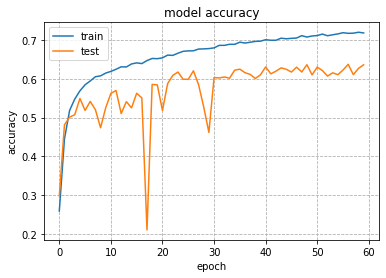

In [10]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(linestyle="--")
plt.legend(['train', 'test'], loc='upper left')
plt.show()

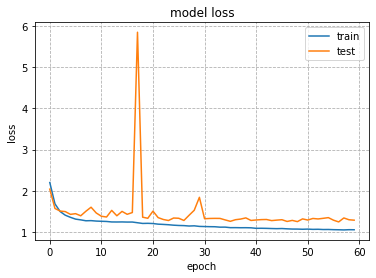

In [11]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(linestyle="--")
plt.legend(['train', 'test'], loc='upper right')
plt.show()